# Description:
In this notebook the some of the properties of the antennas as simulated by NuRadioReco are investigated as a result of weird behaviour seen in simulation results.

We want to explain the two bobble shape of the simulated transit curve for St23Ch20:
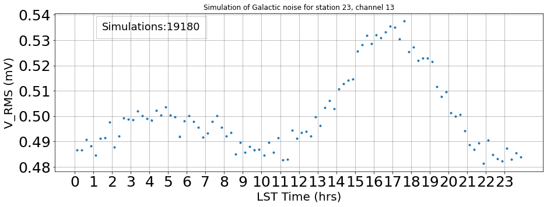

Start by looking at the antenna response:

# Import modules:

In [12]:
from GalaxyFunctions import *

# Import data

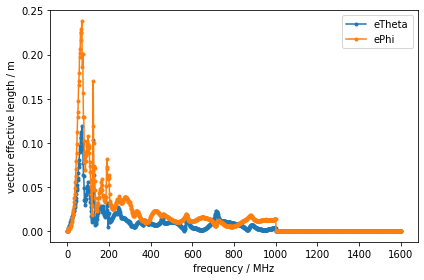

In [17]:
StNr,ChNr,Run,EvtNr,ThermalNoise,Plot=23,20,304,2030,False,False
import NuRadioReco.modules.channelGalacticNoiseAdder as ChannelGalacticNoiseAdder
import NuRadioReco.modules.channelGenericNoiseAdder as ChannelGenericNoiseAdder
import NuRadioReco.examples.cr_efficiency_analysis.helper_cr_eff as hcr
from NuRadioReco.detector import detector
from NuRadioReco.utilities import units, ice, geometryUtilities
from NuRadioReco.framework import event,station, channel
import NuRadioReco.modules.RNO_G.hardwareResponseIncorporator
from datetime import datetime
from datetime import timedelta
import scipy.fft as scfft 
    
WaveFormFile=GetWaveformsFile(StNr,Run)
HeaderFile=GetHeaderFile(StNr,Run)
RadiantData=WaveFormFile['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=WaveFormFile['waveforms']['event_number'].array(library="np")
TriggerTimes=HeaderFile['header']["trigger_time"].array(library='np')
    
EvIdx=np.where(EventNrs==EvtNr)[0][0]
Date=datetime.utcfromtimestamp(TriggerTimes[EvIdx])# - timedelta(hours=2, minutes=0)
    
#define relevant parameters
SamplingTimes=(1/(3.2*10**9))*np.arange(2048) #SampleTimes in seconds

#Obtaining path to relevant json file for detector description
detpath = os.path.dirname(detector.__file__)
detpath+="/RNO_G/RNO_season_2022.json"

#Defining the instances of classes necessary for the simulation
GNDetector = detector.Detector(json_filename = detpath)#,antenna_by_depth=False)
GNDetector.update(Date) #date in example
GNEvent=event.Event(Run,EvtNr)
GNStation=station.Station(StNr)
GNStation.set_station_time(Date)
GNChannel=channel.Channel(ChNr)
GNChannel.set_trace(trace=np.zeros(2048), sampling_rate=3.2 * units.GHz)
GNStation.add_channel(GNChannel) 

channelGalacticNoiseAdder = ChannelGalacticNoiseAdder.channelGalacticNoiseAdder()
GNAntennaPatternProvider=NuRadioReco.detector.antennapattern.AntennaPatternProvider()
    
# signal income direction
#zenith, azimuth = np.deg2rad(0), np.deg2rad(0)
zenith, azimuth = np.deg2rad(80), np.deg2rad(270)

n_ice=ice.get_refractive_index(-0.01, GNDetector.get_site(GNStation.get_id()))
    
for channel in GNStation.iter_channels():
    
    ##Breking radio door ijs
    if GNDetector.get_relative_position(GNStation.get_id(), GNChannel.get_id())[2] < 0:
        t_theta = geometryUtilities.get_fresnel_t_p(zenith, n_ice, 1)
        t_phi = geometryUtilities.get_fresnel_t_s(zenith, n_ice, 1)
        fresnel_zenith = geometryUtilities.get_fresnel_angle(zenith, n_ice, 1.)
        if fresnel_zenith is None:
            continue
    else:
        t_theta = 1
        t_phi = 1
        fresnel_zenith = zenith
        
    #print(channel.get_id())
    antenna_pattern = GNAntennaPatternProvider.load_antenna_pattern(GNDetector.get_antenna_model(GNStation.get_id(), GNChannel.get_id()))
    antenna_orientation = GNDetector.get_antenna_orientation(GNStation.get_id(), GNChannel.get_id())
    freqs = channel.get_frequencies()
    VEL = antenna_pattern.get_antenna_response_vectorized(freqs, zenith, azimuth, *antenna_orientation)

fig, ax = plt.subplots(1, 1)
ax.plot(freqs / units.MHz, np.abs(VEL['theta']), '.-', label='eTheta')
ax.plot(freqs / units.MHz, np.abs(VEL['phi']), '.-', label='ePhi')
ax.set_xlabel("frequency / MHz")
ax.set_ylabel("vector effective length / m")
fig.tight_layout()
ax.legend()
plt.show()

In [21]:
def TransitCurveTest(StNr,ChNr,Runs,NBins=4*24,ZeroAvg=True,TimeFormat="LST",Triggers=(5,5,5,5),StdCut=(-1,-1),FFTFilter=True,Lowpass=False,Plot=True):
    """
    Plots the Average V_RMS as a function of time of the day.
    Parameters:
    StNr,ChNr,Runs=Station number, channel number, list of runs 
    NBins=amount of bins to divide the full day in
    ZeroAvg=Boolean: if true, the timetraces will firs tbe zero averaged
    Lowpass= Boolean: if true, a butterworth lowpass filter will be applied in order to maintain only galactic noise dominated frequencies
    FFTFilter=Boolean: if true, applies a Notch filter to all frequency spectra to cut out frequencies which have shown to be potentially problematic
    TimeFormat= String: Dictates what timeformat the x-axis will be in. Options: "LST": local sidereal time, "LT": Local time & "UTC": UTC time
    Triggers=tupel of flags to dictate which triggers are allowed in the analysis. Events with different triggers are not used (0=has to be absent, 1=has to be present, anything else=both 0 and 1 can be used for analysis)
    StdCut=(AmtStd,StdCut) if larger than zero, all VRMS outliers above StdCut standard variations will be cut out of the analysis. This procedure is repeated AmtStd times.
    """
    (has_rf,has_ext,has_pps,has_soft)=Triggers
    NRuns=0
    EventRMS=np.array([]) #Array to store V_RMS value of each event
    EventTime=np.array([])#Array to store timestamp of each event
    FilteredRuns,FilteredEvNrs=TriggerFilterAlt(StNr, ChNr, Runs,has_rf,has_ext,has_pps,has_soft)
    for Run in FilteredRuns:
        path=Path(StNr,Run)
        #if os.path.isfile(path+"/combined.root"):   
        if os.path.isfile(path+"/waveforms.root") and os.path.isfile(path+"/headers.root"):
            NRuns+=1
            # #If CombinedFile exists:
            # CombinedFile=GetCombinedFile(StNr,Run)
            # RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
            # EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
            # TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
            
            WaveFormFile=GetWaveformsFile(StNr,Run)
            HeaderFile=GetHeaderFile(StNr,Run)
            RadiantData=WaveFormFile['waveforms']['radiant_data[24][2048]'].array(library='np')
            EventNrs=WaveFormFile['waveforms']['event_number'].array(library="np")
            TriggerTimes=HeaderFile['header']["trigger_time"].array(library='np')
            
            RunIdx=np.where(FilteredRuns==Run)[0][0]

            for EvNr in FilteredEvNrs[RunIdx]: ####DO NOT FORGET TO DELETE [0]!!!!
                EvIdx=np.where(EventNrs==EvNr)[0][0]
                if np.isinf(TriggerTimes[EvIdx]):
                    print("Inf timestamp at: Run" + str(Run) + ", EvNr" + str(EvNr))
                    FilteredEvNrs[RunIdx]=np.delete(FilteredEvNrs[RunIdx],np.where(FilteredEvNrs[RunIdx]==EvNr)[0][0])
                    if len(FilteredEvNrs[RunIdx])==0:
                        FilteredRuns=np.delete(FilteredRuns, RunIdx)
                        FilteredEvNrs=np.delete(FilteredEvNrs, RunIdx)
                    continue
                print(RadiantData[EvIdx][ChNr])
                VoltageTrace=ADCtoVoltage(RadiantData[EvIdx][ChNr]) #The timetrace data in voltage
                if ZeroAvg==True:
                    Vmean=np.mean(VoltageTrace)
                    VoltageTrace-=Vmean
                if FFTFilter or Lowpass:
                    import scipy.fft as scfft
                    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
                    TimeStep=1/sampling_rate #Time between two samples
                    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
                    freq=scfft.fftfreq(len(SamplingTimes),(SamplingTimes[-1]-SamplingTimes[0])/len(SamplingTimes))
                    freq=np.fft.fftshift(freq)
                    TotalFilter=np.ones(len(freq))
                    if FFTFilter:
                        TotalFilter=np.multiply(TotalFilter,NotchFilters([403*10**6,120*10**6,807*10**6,1197*10**6],75,freq,sampling_rate))
                    if Lowpass:
                        CritFreq=110*10**6
                        TotalFilter=np.multiply(TotalFilter,LowpassButter(CritFreq,20,freq))
                    FFT=scfft.fft(VoltageTrace)
                    FFT=np.fft.fftshift(FFT)
                    FFT=np.array([FFT[i]*TotalFilter[i] for i in range(len(freq))])
                    VoltageTrace=np.abs(scfft.ifft(FFT))
                EventRMS=np.append(EventRMS,np.sqrt(np.mean([V**2 for V in VoltageTrace])))
                if TimeFormat=="LST":
                    EventTime=np.append(EventTime,LST(TriggerTimes,EvIdx))
                elif TimeFormat=="LT": #Greenland Timezone is UTC-3
                    EventTime=np.append(EventTime,LT(TriggerTimes,EvIdx))
                else:
                    print("Please enter a valid TimeFormat")
                    return
     
#     EventTimeCounts, EventTimeBins=np.histogram(EventTime, bins=NBins,range=(0,24),density=False) #Storing timestamps in histogram format
#     MidBins= np.array([(EventTimeBins[i] + EventTimeBins[i+1])/2 for i in range(0,len(EventTimeBins)-1)])
#     #Make a histogram of the V_RMS value fully added in its respective bin by adding V_RMS as a weigth to the additions to the histogram
       
#     EventTimeDig=np.digitize(EventTime,EventTimeBins)
#     VRMSIdx=np.arange(len(EventRMS))
#     GroupedVRMS=np.empty((NBins,),dtype=object)
#     GroupedVRMSIdx=np.empty((NBins,),dtype=object)
#     for i in range(len(EventTimeDig)):
#         GroupedVRMS[EventTimeDig[i]-1]=np.append(GroupedVRMS[EventTimeDig[i]-1],EventRMS[i])
#         GroupedVRMSIdx[EventTimeDig[i]-1]=np.append(GroupedVRMSIdx[EventTimeDig[i]-1],VRMSIdx[i])
#     ##Get rid of "None" entries in beginning of array
#     for i in range(len(GroupedVRMS)):
#         GroupedVRMS[i]=np.delete(GroupedVRMS[i], 0)
#         GroupedVRMSIdx[i]=np.delete(GroupedVRMSIdx[i], 0)
    print(EventRMS)
    MidBins, GroupedVRMS=GroupVRMS(EventRMS,EventTime,NBins)

    ####Quality cuts:
    ##Hard cut
    if False:
        HardCut=0.0035 #Cut of VRMS in Voltage
        for i in range(len(GroupedVRMS)):
            for VRMSIdx, VRMS in enumerate(GroupedVRMS[i]):
                if VRMS>HardCut:
                    EventRMSIdx=np.where(EventRMS==VRMS)[0][0]
                    FilteredRuns,FilteredEvNrs=StdCutRunEvtsFilter(EventRMSIdx,FilteredRuns,FilteredEvNrs)
                    EventRMS=np.delete(EventRMS, EventRMSIdx)
                    EventTime=np.delete(EventTime, EventRMSIdx)
                    GroupedVRMS[i]=np.delete(GroupedVRMS[i], np.where(GroupedVRMS[i]==VRMS)[0][0])

    ##Std Cut
    if np.all(np.array(StdCut)>0):
        for StdAmt in range(StdCut[0]):
            #Compute std per bin
            ## Here you do not divide std by sqrt(len(GroupedVRMS[i])) because here you want to use the width of the distribution and not the uncertainty on the mean!!!
            VRMSStd=np.array([np.std(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])
            VRMSMedian=np.array([np.median(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])
            for i in range(len(GroupedVRMS)):
                for VRMSIdx, VRMS in enumerate(GroupedVRMS[i]):
                    if not VRMSMedian[i] - StdCut[1]*VRMSStd[i]<VRMS<VRMSMedian[i] + StdCut[1]*VRMSStd[i]:
                        EventRMSIdx=np.where(EventRMS==VRMS)[0][0]
                        FilteredRuns,FilteredEvNrs=StdCutRunEvtsFilter(EventRMSIdx,FilteredRuns,FilteredEvNrs)
                        EventRMS=np.delete(EventRMS, EventRMSIdx)
                        EventTime=np.delete(EventTime, EventRMSIdx)
                        GroupedVRMS[i]=np.delete(GroupedVRMS[i], np.where(GroupedVRMS[i]==VRMS)[0][0])
    
    if Plot:
        EventRMSCounts, EventRMSBins=np.histogram(EventTime, bins=NBins,range=(0,24),density=False,weights=EventRMS) 
        
        VRMSAvg=np.array([np.mean(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])
        VRMSStd=np.array([np.std(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])

        plt.figure(figsize=(15,5))
        plt.figtext(0.2, 0.8, "Entries:" + str(len(EventTime)), fontsize=18,bbox=dict(edgecolor='black', facecolor='none', alpha=0.2, pad=10.0))
        plt.errorbar(MidBins,1000*VRMSAvg,yerr=1000*VRMSStd,fmt=".",zorder=2)
        for i in range(len(GroupedVRMS)):
            plt.plot(MidBins[i]*np.ones(len(GroupedVRMS[i])),1000*GroupedVRMS[i],"r.", alpha=0.5,zorder=1)
        plt.grid(color='grey', linestyle='-', linewidth=1,alpha=0.5)
        plt.title("V_RMS of Station " + str(StNr) + ", channel " + str(ChNr) + " for " + str(NRuns) + " events between run " + str(Runs[0]) + " and run " + str(Runs[-1]) + " throughout the day for " + str(NBins) + " bins")
        plt.xlabel(TimeFormat + " Time (hrs)",fontsize=20)#20)
        plt.ylabel("V_RMS (mV)",fontsize=20)#20)
        plt.xticks(np.arange(0, 24, 1.0),fontsize=25)#15)
        plt.yticks(fontsize=25)#15)
        plt.show()
    return EventTime, EventRMS, MidBins, GroupedVRMS, FilteredRuns,FilteredEvNrs

[  3   7   6 ...  12  -1 -13]
[ 0 -7 -3 ...  1 -6 -5]
[  2   6   7 ... -14 -13 -19]
[ 1  8 13 ... -9 -4 -2]
[ 1 12 18 ...  0  8 20]
[-16 -14  -4 ...  14  16   8]
[  7 -11 -17 ...   7   0  -7]
[ 3  1  0 ... -1  3 11]
[-1 -7 -6 ... -4 -7 -4]
[13 34 28 ... -1 -4 -4]
[-21 -14   1 ...  -8  -4   5]
[-10  -9   7 ...  12  17  18]
[-6 -8 -8 ... -5  0  9]
[-15 -22 -27 ...  -2  -2  -5]
[15 12  2 ... -1  5 10]
[ -1  12  20 ... -15 -10   3]
[ -8  -6   0 ...   0 -11  -9]
[  8  19  18 ... -10  -9 -14]
[-21 -31 -21 ... -13 -14   3]
[ 3 -4 -5 ...  0 11 16]
[ 3  4  0 ... -4  0  6]
[-10  -6   3 ...  -3   5   0]
[  0 -17 -17 ...  13   8   2]
[ 1 -2 -4 ... -8  5 14]
[ -1 -10  -9 ...   7   0  -9]
[ -7 -14  -8 ...   0   8  10]
[ 8  2  3 ... -3 -3  4]
[ 8 10  9 ... -7 -1 10]
[ -2 -11 -11 ...   5 -10 -22]
[19 26 12 ... -8 -9 -9]
[-12 -15  -5 ...   3   8   1]
[-11 -14 -12 ...   8   4  -4]
[ -1  -5  -9 ...  -9 -13  -7]
[  1   7  10 ... -28 -22 -18]
[  8   3 -10 ...  10  13   3]
[-5 -1 -5 ... -1  0  3]
[ 11  14  

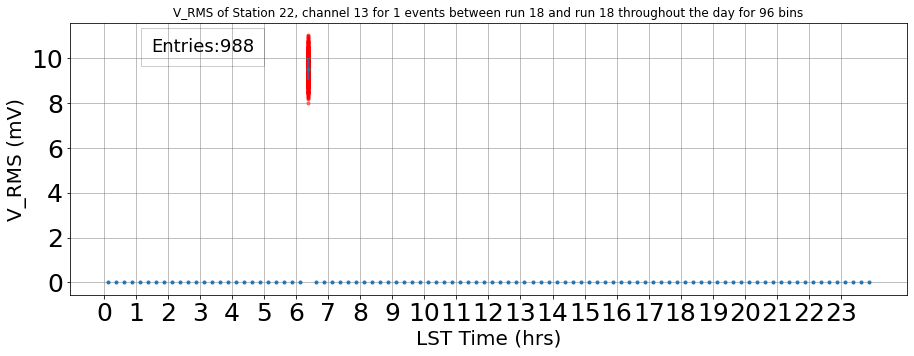

(array([6.41117298, 6.41127149, 6.41132773, 6.4114232 , 6.41147947,
        6.411575  , 6.41163446, 6.41173001, 6.41181424, 6.41191   ,
        6.41199414, 6.41209024, 6.41218578, 6.41227004, 6.41236573,
        6.41244996, 6.4125463 , 6.41264178, 6.41269801, 6.4127937 ,
        6.41287785, 6.41297471, 6.41305948, 6.41315436, 6.41325059,
        6.41330676, 6.41340247, 6.41348664, 6.41358415, 6.41366825,
        6.41376319, 6.41385885, 6.41391506, 6.41401091, 6.41409509,
        6.41419324, 6.41427892, 6.41437427, 6.41447136, 6.41452762,
        6.41462468, 6.41468162, 6.41477726, 6.41486139, 6.41495696,
        6.41504111, 6.41513638, 6.41523184, 6.41531591, 6.41541142,
        6.41549559, 6.41559061, 6.41568792, 6.41574536, 6.41584376,
        6.41589994, 6.41599542, 6.41607962, 6.41617602, 6.41626016,
        6.41635518, 6.41645075, 6.41653488, 6.41663053, 6.41671472,
        6.4168098 , 6.41690528, 6.41696147, 6.41705987, 6.41714404,
        6.41723961, 6.41732376, 6.41741911, 6.41

In [22]:
RunList=np.concatenate((np.arange(18,23),np.arange(91,111)))
for BadRun in [97,98]:
    RunList=np.delete(RunList,np.where(RunList==BadRun)[0][0])
TransitCurveTest(22,13,[18],NBins=4*24,ZeroAvg=False,TimeFormat="LST",Triggers=(5,5,5,5),StdCut=(-1,-1),FFTFilter=False,Lowpass=False,Plot=True)

In [23]:
print(FilteredEvNrs[0][0],FilteredEvNrs[0][-1])
print(all(FilteredEvNrs[0]==np.arange(0,22965)))

0 22964
True


In [4]:
StNr,ChNr,RunNr=22,13,21
WaveFormFile=GetWaveformsFile(StNr,RunNr)
HeaderFile=GetHeaderFile(StNr,RunNr)
RadiantData=WaveFormFile['waveforms']['radiant_data[24][2048]'].array(library='np')
EventNrs=WaveFormFile['waveforms']['event_number'].array(library="np")
TriggerTimes=HeaderFile['header']["trigger_time"].array(library='np')
TriggerInfo=TrigInfo(StNr,ChNr,RunNr)

In [8]:
EvIdx=np.where(EventNrs==22962)[0][0]
Triggers=[TriggerInfo['trigger_info.which_radiant_trigger'][EvIdx]<-100,TriggerInfo["trigger_info.ext_trigger"][EvIdx],TriggerInfo["trigger_info.pps_trigger"][EvIdx],TriggerInfo["trigger_info.force_trigger"][EvIdx]]
print(Triggers)

[True, False, False, False]


# Plot radio skymodel

Reference point for galaxy in equatorial coordinates: <br>
RA=17hr 45m 40.04s <br>
DEC=-29deg 00' 28.1"
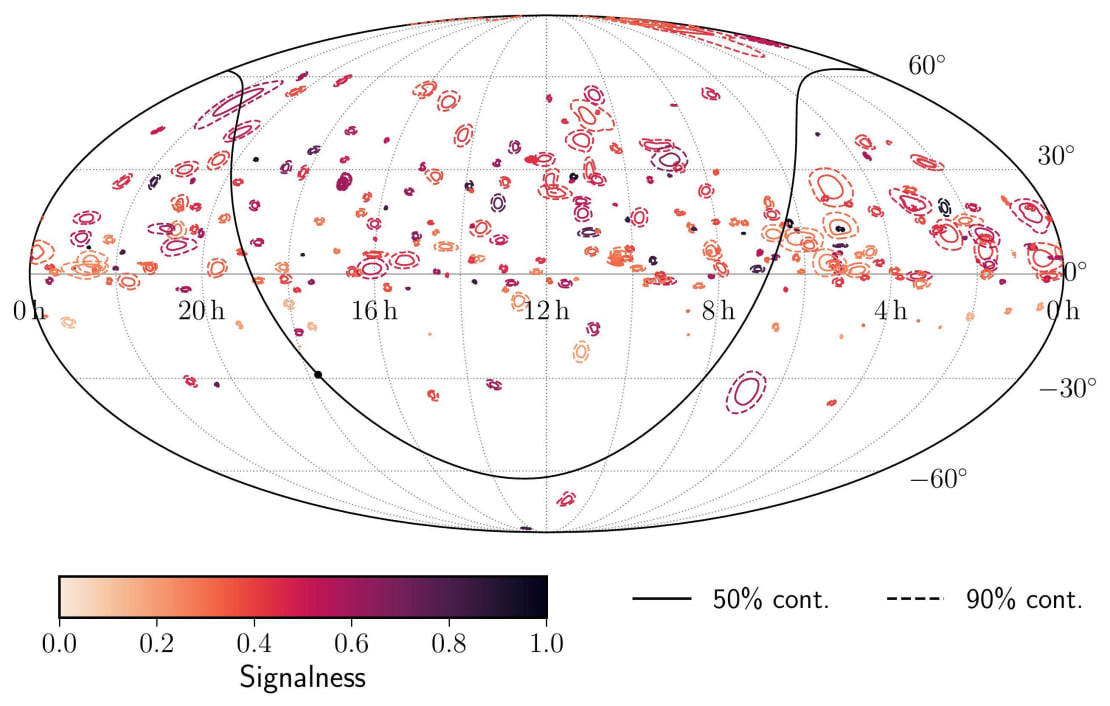

https://github.com/telegraphic/pygdsm/blob/master/docs/pygdsm_quickstart.ipynb

In [56]:
import pygdsm
import healpy as hp
import numpy as np
import matplotlib as mpl
#from healpy.newvisufunc import projview, newprojplot

(3145728,)
(3072,)


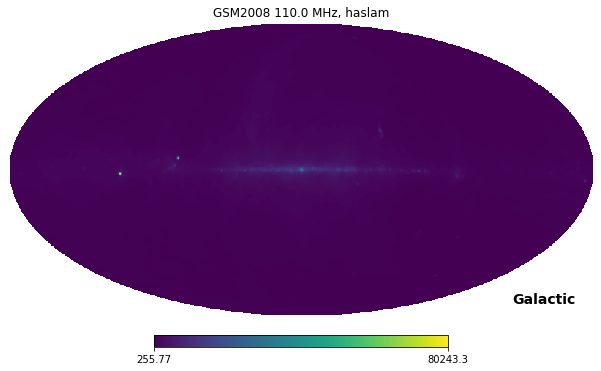

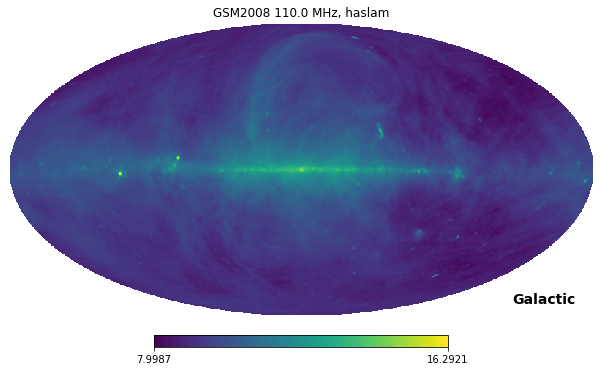

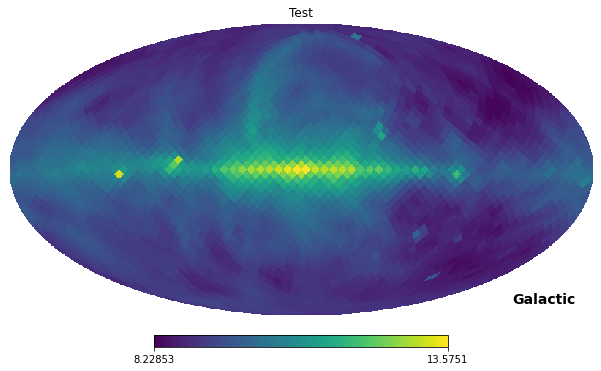

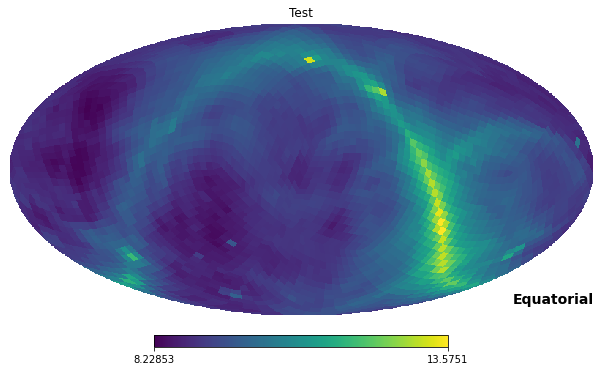

In [60]:
gsm = pygdsm.pygsm.GlobalSkyModel()
radio_sky=gsm.generate(110)
print(radio_sky.shape)
gsm.view(logged=False)
gsm.view(logged=True)
n_side=16
radio_sky = hp.pixelfunc.ud_grade(radio_sky, n_side)
print(radio_sky.shape)
radio_sky = np.log2(radio_sky)
hp.mollview(radio_sky, coord='G', title='Test')
hp.mollview(radio_sky, coord='GC', title='Test')


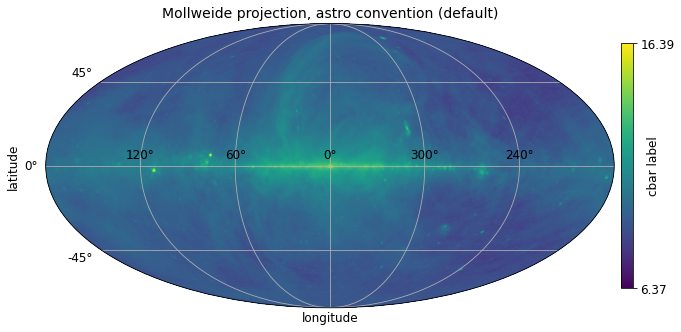

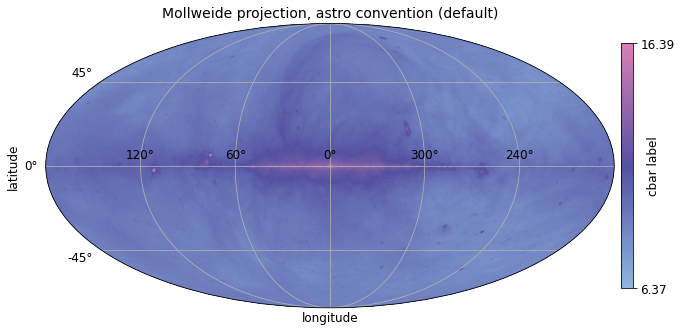

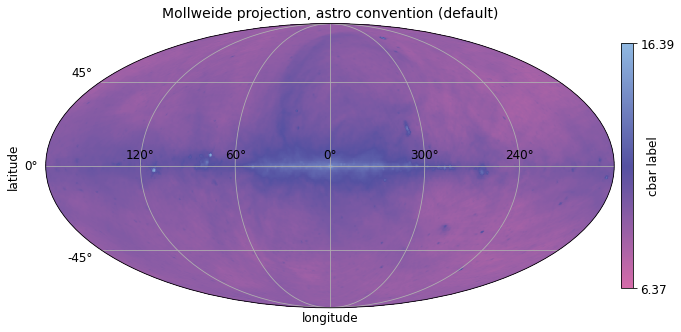

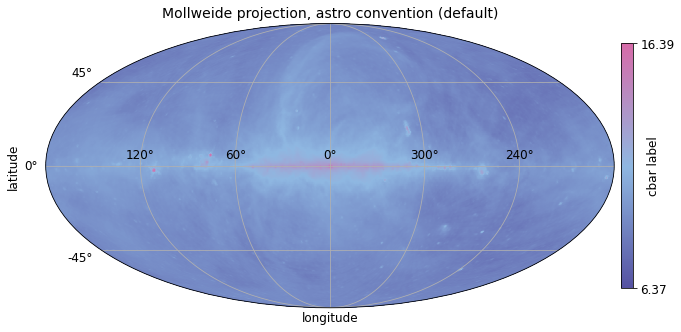

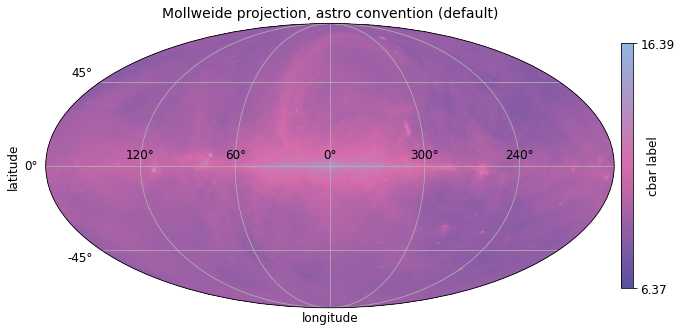

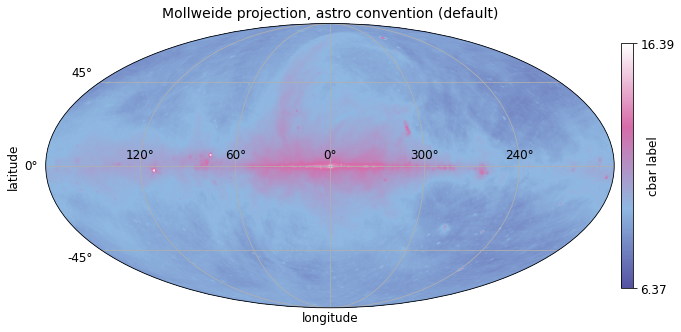

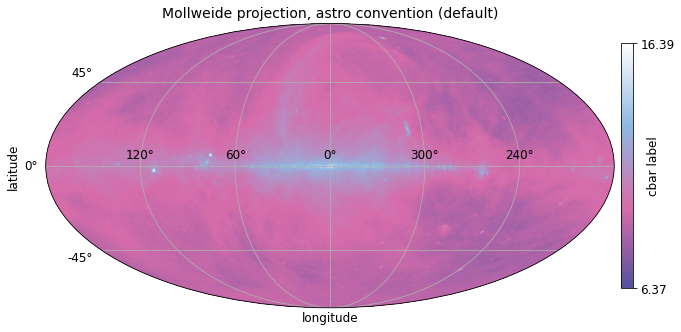

In [20]:
for ColorMap in ['viridis',MakeCM3(BkgGradBlueRGB,PurpleLinesRGB,PinkLightRGB),MakeCM3(PinkDarkRGB,PurpleLinesRGB,BkgGradBlueRGB),
                MakeCM3(PurpleLinesRGB,BkgGradBlueRGB,PinkDarkRGB),MakeCM3(PurpleLinesRGB,PinkDarkRGB,BkgGradBlueRGB),
                MakeCM4(PurpleLinesRGB,BkgGradBlueRGB,PinkDarkRGB,(255, 255, 255),N=256),MakeCM4(PurpleLinesRGB,PinkDarkRGB,BkgGradBlueRGB,(255, 255, 255),N=256)]:
    hp.newvisufunc.projview(
        radio_sky,
        coord=["G"],
        graticule=True,
        graticule_labels=True,
        unit="cbar label",
        xlabel="longitude",
        ylabel="latitude",
        cb_orientation="vertical",
        cmap=ColorMap,
        min=np.min(radio_sky),
        max=np.max(radio_sky),
        latitude_grid_spacing=45,
        projection_type="mollweide",
        title="Mollweide projection, astro convention (default)",
    );

In [2]:
def RadioSkyMap(n_side=512,LogScale=True,Coord="G",Rot=(180,0,0),FOVMask=False,FileName=None):
    import pygdsm
    import healpy as hp
    import numpy as np
    import matplotlib as mpl
    import astropy

    gsm = pygdsm.pygsm.GlobalSkyModel()
    radio_sky=gsm.generate(110)
    #gsm.view(logged=True)
    if n_side<512:
        radio_sky = hp.pixelfunc.ud_grade(radio_sky, n_side)
    if FOVMask==True:
        FOVDecLimit=(72+ 34/60)-90
        pixel_longitudes, pixel_latitudes = hp.pixelfunc.pix2ang(n_side, range(hp.pixelfunc.nside2npix(n_side)), lonlat=True)
        galactic_coordinates = astropy.coordinates.Galactic(l=pixel_longitudes*(np.pi/180) * astropy.units.rad, 
                                                                b=pixel_latitudes*(np.pi/180) * astropy.units.rad)
        ICRS_coordinates = galactic_coordinates.transform_to(astropy.coordinates.ICRS)
        Decs=np.array([ICRS_coordinates[i].dec.degree for i in range(len(ICRS_coordinates))])
        radio_sky=np.ma.masked_where(Decs<FOVDecLimit, radio_sky, copy=True)
        #print(pixel_latitudes)
    Spacing=60
    SpacingFrac=Spacing/360
    
    radio_sky = np.log10(radio_sky)
    # CBarMin=np.floor(1*np.min(radio_sky))
    # CBarMax=np.rint(1*np.max(radio_sky))
    CBarMin=np.min(radio_sky)
    CBarMax=np.max(radio_sky)

    ColorMap=MakeCM4(PurpleLinesRGB,BkgGradBlueRGB,PinkDarkRGB,(255, 255, 255),N=256)
    hp.newvisufunc.projview(
            radio_sky,
            coord=Coord,
            graticule=True,
            graticule_labels=False,
            graticule_color=(0, 0, 0, 1),
            latitude_grid_spacing=30,
            longitude_grid_spacing=Spacing,
            rot=Rot,
            phi_convention='symmetrical',
            unit=r"log($T_{Ant}$)",
            # ylabel="Declination",
            # xlabel="Right Ascension",
            cb_orientation="vertical",
            cmap=ColorMap,
            hold=True,
            min=8/3.322,
            max=14/3.322,
            projection_type="mollweide",
            # table=False,
            #title="Mollweide projection, astro convention (default)")
            #Original fontsizes: fontsize=dict(cbar_label = 15, cbar_tick_label=15,xlabel=20,ylabel=20,xtick_label=15,ytick_label=15) #“xlabel”, “ylabel”, “title”, “xtick_label”, “ytick_label”, “cbar_label”, “cbar_tick_label”
            fontsize=dict(cbar_label = 30, cbar_tick_label=30,xlabel=40,ylabel=40,xtick_label=20,ytick_label=20) #“xlabel”, “ylabel”, “title”, “xtick_label”, “ytick_label”, “cbar_label”, “cbar_tick_label”
    );
    #xlimmin,xlimmax=-2.01,2.01
    if Coord!="G":
        # XTicksLabel=np.array([ str(int(deg))+"°" for deg in np.array(360-Spacing*np.arange(1,370/Spacing-1,1))])
        XTicksLabel=np.array([ str(int(hr))+"h" for hr in 24*np.array(1-SpacingFrac*np.arange(1,25/(SpacingFrac*24)-1,1))])
        plt.xticks(ticks=plt.xticks()[0], labels=XTicksLabel,fontsize=20)#15)
    #>plt.figtext(0.35, 0.3, "Plot still WIP!", fontsize=18,color='r')
    if FileName!=None:
        plt.savefig("Figures/" + FileName+".svg", format="svg",bbox_inches='tight')
    plt.show()
    return

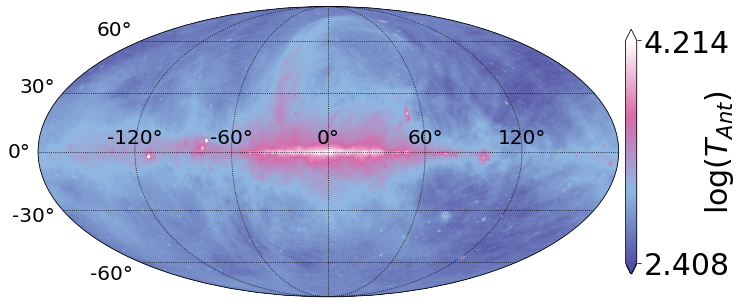

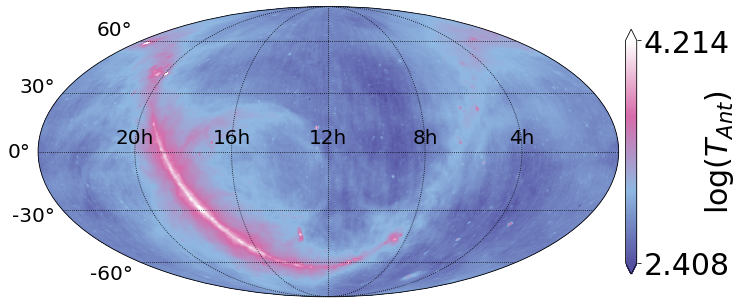

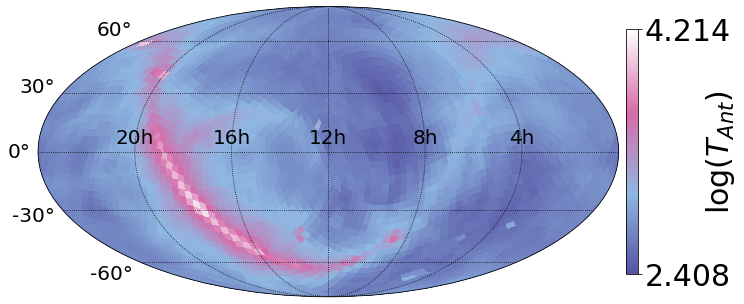

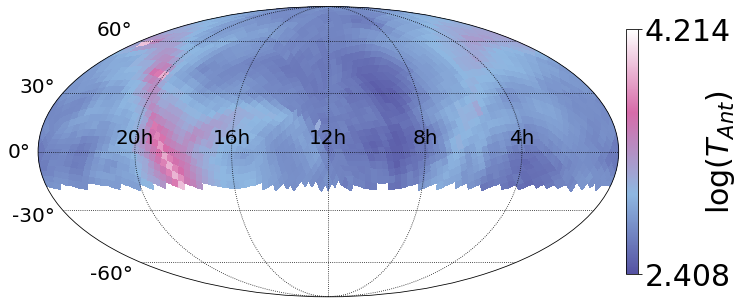

In [5]:
RadioSkyMap(Rot=(0,0,0),FileName="RadioSkyGalCoord")
RadioSkyMap(Coord="GC",FileName="RadioSkyEqCoord")
RadioSkyMap(n_side=16,Coord="GC",FileName="RadioSkyPixel")
RadioSkyMap(n_side=16,Coord="GC",FOVMask=True,FileName="RadioSkyClipped")

In [ ]:
RadioSkyMap(Coord="GC",FOVMask=True,FileName="RadioSkyHDClipped")

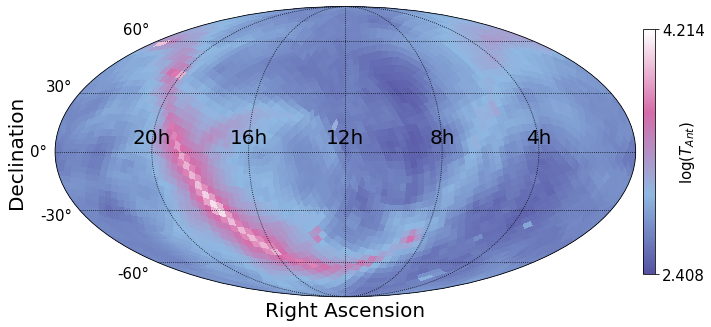

3072


In [3]:
RadioSkyMap(n_side=16,Coord="GC",FileName="RadioSkyPixel")

In [6]:
12*(16**2)

3072

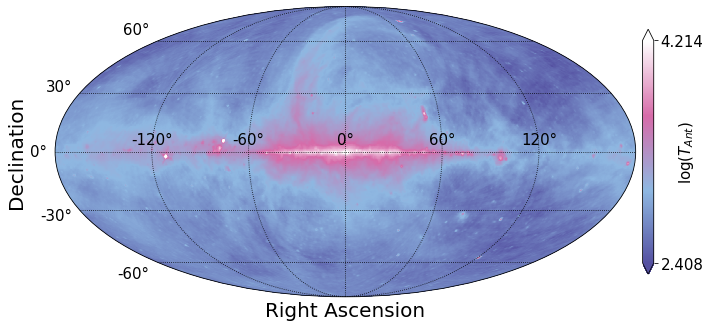

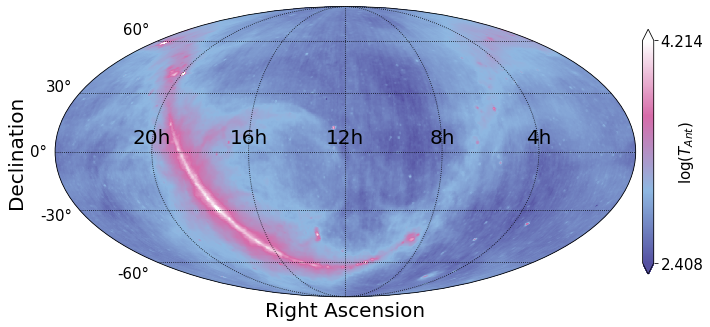

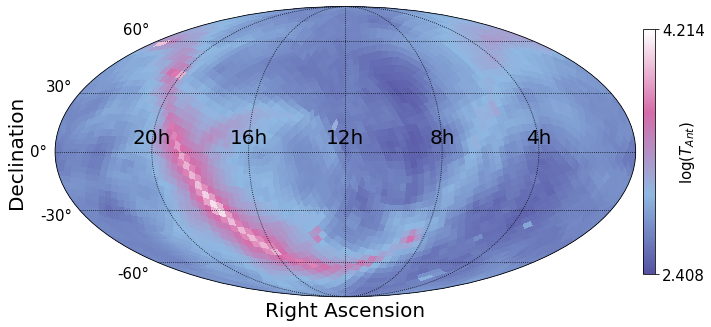

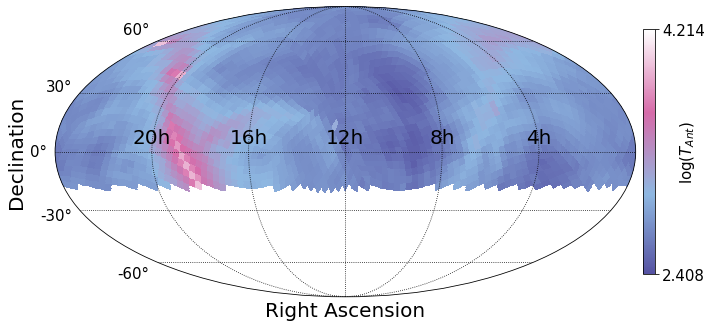

In [9]:
RadioSkyMap(Rot=(0,0,0),FileName="RadioSkyGalCoord")
RadioSkyMap(Coord="GC",FileName="RadioSkyEqCoord")
RadioSkyMap(n_side=16,Coord="GC",FileName="RadioSkyPixel")
RadioSkyMap(n_side=16,Coord="GC",FOVMask=True,FileName="RadioSkyClipped")

In [128]:
TArray=np.arange(15)
print(TArray)
print(np.flip(TArray))
print(RS)
print(np.flip(RS))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[14 13 12 11 10  9  8  7  6  5  4  3  2  1  0]
[2.01539004 2.00309162 1.98482423 ... 1.9261405  1.93747978 1.92882221]
[1.92882221 1.93747978 1.9261405  ... 1.98482423 2.00309162 2.01539004]


In [ ]:
gdsm = pygdsm.pygsm.GlobalSkyModel()
site_latitude, site_longitude = detector.get_site_coordinates(station.get_id())
site_location = astropy.coordinates.EarthLocation(lat=site_latitude * astropy.units.deg, lon=site_longitude * astropy.units.deg)
station_time = station.get_station_time()
station_time.format = 'iso'
noise_temperatures = np.zeros((len(self.__interpolaiton_frequencies), healpy.pixelfunc.nside2npix(self.__n_side)))
local_cs = astropy.coordinates.AltAz(location=site_location, obstime=station_time)
solid_angle = healpy.pixelfunc.nside2pixarea(self.__n_side, degrees=False)
pixel_longitudes, pixel_latitudes = healpy.pixelfunc.pix2ang(self.__n_side, range(healpy.pixelfunc.nside2npix(self.__n_side)), lonlat=True)
pixel_longitudes *= units.deg
pixel_latitudes *= units.deg
galactic_coordinates = astropy.coordinates.Galactic(l=pixel_longitudes * astropy.units.rad, b=pixel_latitudes * astropy.units.rad)
local_coordinates = galactic_coordinates.transform_to(local_cs)
n_ice = ice.get_refractive_index(-0.01, detector.get_site(station.get_id()))
# save noise temperatures for all directions and frequencies
for i_freq, noise_freq in enumerate(self.__interpolaiton_frequencies):
        radio_sky = gdsm.generate(noise_freq / units.MHz)
        radio_sky = healpy.pixelfunc.ud_grade(radio_sky, self.__n_side)
        noise_temperatures[i_freq] = radio_sky

# Data cleaning plots

## Timetrace + VRMS

In [28]:
def TimeTraceVRMS(StNr,ChNr,Run,EvNr,Amplitude="V"):
    """Show the timetrace of Station StNr, channel ChNr for run Run, event EvNr. Units of Ampllitude can be V,mV or ADC together with the VRMS value"""
    path=Path(StNr,Run)
    if os.path.isfile(path+"/combined.root") and os.path.isfile(path+"/daqstatus.root"):   
        CombinedFile=GetCombinedFile(StNr,Run)
        RadiantData=CombinedFile['combined']['waveforms']['radiant_data[24][2048]'].array(library='np')
        EventNrs=CombinedFile['combined']['waveforms']['event_number'].array(library="np")
        #TriggerTimes=CombinedFile['combined']['header']["trigger_time"].array(library='np')
        EvIndex=np.where(EventNrs==EvNr)[0][0]
    elif os.path.isfile(path+"/waveforms.root"):
        WaveFormFile=GetWaveformsFile(StNr,Run)
        EventNrs=WaveFormFile['event_number'].array(library="np")
        EvIdx=np.where(EventNrs==EvNr)[0][0]
        RadiantData=WaveFormFile['waveforms']['radiant_data[24][2048]'].array(entry_start=EvIdx, entry_stop=EvIdx+1,library='np')
        #RadiantData=WaveFormFile['radiant_data[24][2048]'].array(library='np')
        EvIndex=0
    else:
        print("Root files not present")
        return
    
    if not EvNr in EventNrs:
        print("There is no event with this number")
        return
        
    

    sampling_rate=3.2 * (10**9) #Sampling rate in Hertz according to the python file of NuRadioReco.modules.io.rno_g
    TimeStep=1/sampling_rate #Time between two samples
    SamplingTimes=np.arange(0,len(RadiantData[0][0])*TimeStep,TimeStep)
    
    fig=plt.figure(figsize=(20,5))
    ax = fig.add_subplot(111)
    
    if Amplitude=="V":
        VoltageTrace=ADCtoVoltage(RadiantData[EvIndex][ChNr])
        Vmean=np.mean(VoltageTrace)
        VoltageTrace-=Vmean
        plt.plot(SamplingTimes*(10**9),VoltageTrace,'-', label="Channel " + str(ChNr))
        plt.plot(SamplingTimes*(10**9),np.sqrt(np.mean([V**2 for V in VoltageTrace]))*np.ones(len(SamplingTimes)))
        plt.ylabel("Amplitude (V)",fontsize=40)#20)
    elif Amplitude=="mV":
        VoltageTrace=1000*ADCtoVoltage(RadiantData[EvIndex][ChNr])
        Vmean=np.mean(VoltageTrace)
        
        # if Vmean>0:
        #     OffsetStr="-" + str(np.round(Vmean,3))
        # else:
        #     OffsetStr= "+" + str(np.abs(np.round(Vmean,3)))
        
        VoltageTrace-=Vmean
        plt.plot(SamplingTimes*(10**9),VoltageTrace,'-', label="Timetrace ",color="#d76caa",zorder=1)
        plt.plot(SamplingTimes*(10**9),np.sqrt(np.mean([V**2 for V in VoltageTrace]))*np.ones(len(SamplingTimes)),color="#7565ad",zorder=2,linestyle=(0, (5, 5)),linewidth=3.5,label="$V_{\mathbf{Std}}$ of timetrace")
        plt.ylabel("Amplitude (mV)",fontsize=40,fontweight="bold")#20)
        # plt.plot(SamplingTimes*(10**9),np.zeros(len(SamplingTimes)),color="k",zorder=2,linestyle=(0, (5, 5)),linewidth=2)
        ax.axhline(y = 0, color = 'k', linestyle = ':',alpha=0.75,linewidth=3.5)
    elif Amplitude=="ADC":
        plt.plot(SamplingTimes*(10**9),RadiantData[EvIndex][ChNr],'-', label="Channel " + str(ChNr))
        plt.ylabel("Amplitude (ADC)",fontsize=40)#20)        
    #plt.plot(Energies,TritonEnergyLoss,'-',color='r', label="Triton")
    #plt.title("Time trace of St" + str(StNr) + ", Ch" + str(ChNr) + ", Run " + str(Run) + ", Evt " + str(EvNr),fontsize=50)#25)
    #plt.ylim(-50,50)
    plt.legend(fontsize=25,loc="lower right",prop={"weight":"bold","size":25})
    plt.setp(ax.spines.values(), lw=5, color='k')
    plt.xlim(0,np.max(SamplingTimes*(10**9)))
    plt.xlabel("Time (ns)",fontsize=40,fontweight="bold")#20)
    plt.xticks(fontsize=30,fontweight="bold")#15)
    plt.yticks(fontsize=30,fontweight="bold")#15)
    ax.xaxis.set_tick_params(width=5,length=8)
    ax.yaxis.set_tick_params(width=5,length=8)
    plt.savefig("Figures/TimeTraceVRMS"+str(StNr)+"Ch" + str(ChNr)+".pdf", format="pdf", bbox_inches="tight")

In [13]:
StNr,ChNr,DataSample,DataFileId=23,16,"HC","2255472-Tot"
FilteredRuns=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "FilteredRuns_" + str(DataFileId) + ".npy",allow_pickle=True)
FilteredEvents=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "FilteredEvNrs_" + str(DataFileId) + ".npy",allow_pickle=True)

In [14]:
i,j=25,60
Run,EvNr=int(FilteredRuns[i]),FilteredEvents[i][j]

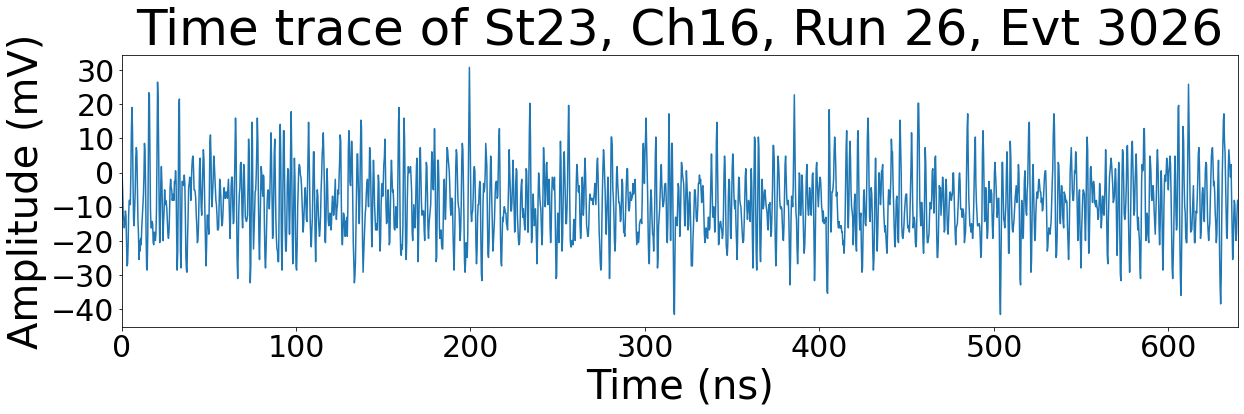

In [5]:
TimeTrace(StNr,ChNr,Run,EvNr,Amplitude="mV")

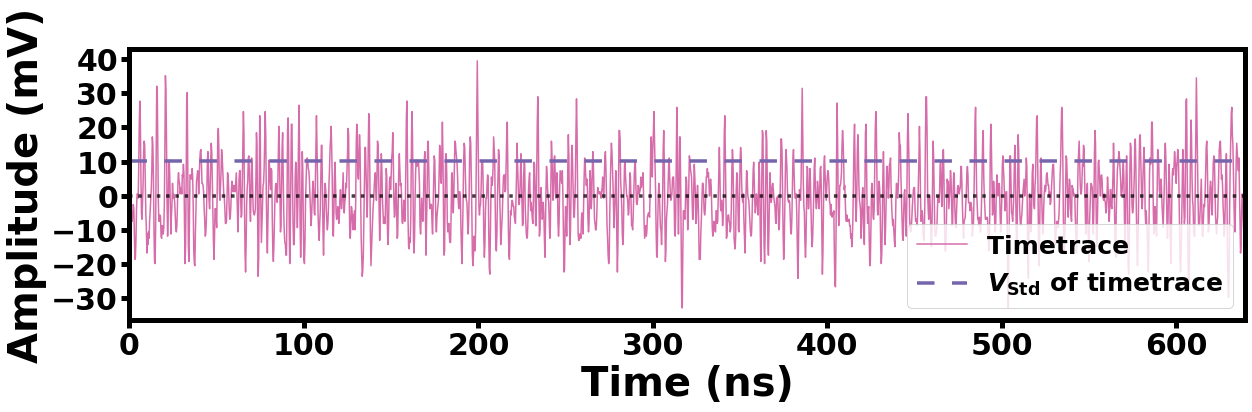

In [29]:
TimeTraceVRMS(StNr,ChNr,Run,EvNr,Amplitude="mV")

## VRMS Distribution

Transit curve without 2x3$\sigma$ cut and quality cut:

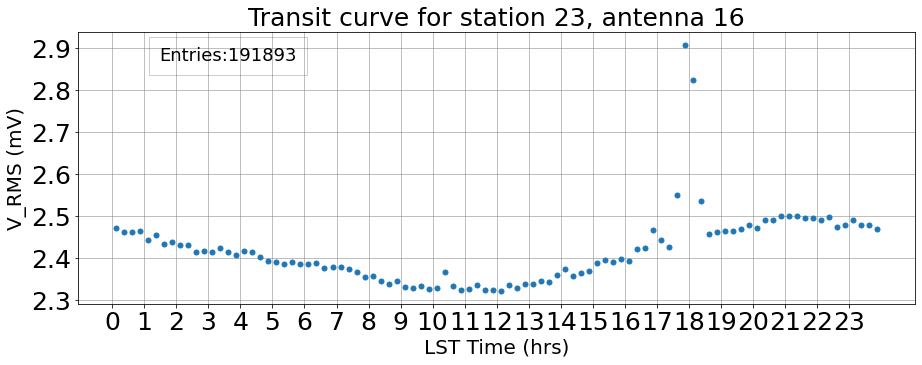

In [2]:
TransitCurveSingular(23,16,"HC","3277351-Tot",NBins=0)

In [7]:
def VRMSBinHist(StNr,ChNr, DataSample,DataFileId,BinNr=0):
    """ Plots the data transit curve results from files stored away in the JobResults folder structure.
    Parameters:
    StNr= Station number.
    ChNr= Channel number
    DataSample= String that can be "C" for combined, "HC" for handcarry or "S" for Satellite 
    DataFileId= Name of the file where the data is stored.
    NBins= Amount of bins the transit curve should have.
    """
    #Plots the transit curves from JobsResults for a file with name "FileId, station StNr, channel ChNr, binned in NBins bins(set NBins=0 for the already binned data)"
    #DataSample can be "C" for combined, "HC" for handcarry or "S" for Satellite     
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib

    GroupedVRMS=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "GroupedVRMS_" + str(DataFileId) + ".npy",allow_pickle=True)
    MidBins=np.load("JobResults/Data/St" + str(StNr) + "Ch" + str(ChNr) + "/" + DataSample + "MidBins_" + str(DataFileId) + ".npy",allow_pickle=True)
    VRMSVals1=GroupedVRMS[BinNr]
    DataEntries=len(VRMSVals1)
    
    VRMSVals2=VRMSVals1[:]
    HardCut=0.0035
    for VRMSIdx, VRMS in enumerate(VRMSVals2):
        if VRMS>HardCut:
            VRMSVals2=np.delete(VRMSVals2, np.where(VRMSVals2==VRMS)[0][0])

    StdCut=3
    
    VRMSVals3=VRMSVals2[:]
    ##Std Cut
    #Compute std per bin
    ## Here you do not divide std by sqrt(len(GroupedVRMS[i])) because here you want to use the width of the distribution and not the uncertainty on the mean!!!
    VRMSStd2=np.std(VRMSVals3)
    VRMSMedian2=np.median(VRMSVals3)
    for VRMSIdx, VRMS in enumerate(VRMSVals3):
        if not VRMSMedian2 - StdCut*VRMSStd2<VRMS<VRMSMedian2 + StdCut*VRMSStd2:
            VRMSVals3=np.delete(VRMSVals3, np.where(VRMSVals3==VRMS)[0][0])
            
    VRMSVals4=VRMSVals3[:]
    ##Std Cut
    #Compute std per bin
    ## Here you do not divide std by sqrt(len(GroupedVRMS[i])) because here you want to use the width of the distribution and not the uncertainty on the mean!!!
    VRMSStd3=np.std(VRMSVals4)
    VRMSMedian3=np.median(VRMSVals4)
    for VRMSIdx, VRMS in enumerate(VRMSVals4):
        if not VRMSMedian3 - StdCut*VRMSStd3<VRMS<VRMSMedian3 + StdCut*VRMSStd3:
            VRMSVals4=np.delete(VRMSVals4, np.where(VRMSVals4==VRMS)[0][0])
    
    
    #Compute statistics
    VRMSAvg=np.array([np.mean(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])
    VRMSStd=np.array([np.std(GroupedVRMS[i])/len(GroupedVRMS[i]) if len(GroupedVRMS[i])!=0 else 0 for i in range(len(GroupedVRMS))])

    #Counts, Bins=np.histogram(VRMSVals, bins="auto")
    fig=plt.figure(figsize=(20,5))
    ax = fig.add_subplot(111)
    ymin=5e-3
    matplotlib.rcParams['font.weight'] = 'bold'
    # matplotlib.rc('text', usetex=True)
    # plt.rcParams['text.latex.preamble'] = r"\usepackage{bm} \usepackage{amsmath}"
    NSteps=200
    #plt.errorbar(MidBins,1000*VRMSAvg,yerr=1000*VRMSStd,fmt=".",zorder=2,markersize=10)
    n,bins,p=plt.hist(1000*VRMSVals2,bins="auto",color="#d76caa",density=True)
    #plt.hist(1000*VRMSVals3,bins=bins)
    plt.plot(1000*(VRMSMedian2-3*VRMSStd2)*np.ones(NSteps),1.2*np.linspace(ymin,5*np.log(np.max(n)),NSteps),color="#5551a2",zorder=2,linestyle=(0, (5, 5)),linewidth=3.5)
    plt.plot(1000*(VRMSMedian2+3*VRMSStd2)*np.ones(NSteps),1.2*np.linspace(ymin,5*np.log(np.max(n)),NSteps),color="#5551a2",zorder=2,linestyle=(0, (5, 5)),linewidth=3.5)
    plt.plot(1000*(VRMSMedian2)*np.ones(NSteps),1.2*np.linspace(ymin,5*np.log(np.max(n)),NSteps),color="#5551a2",zorder=2,linestyle=(0, (5, 5)),linewidth=3.5)
    #plt.plot(1000*(VRMSMedian3-3*VRMSStd3)*np.ones(NSteps),1.2*np.linspace(0,np.max(n),NSteps),color="#8378b7",zorder=2,linestyle=(0, (5, 5)),linewidth=3.5)
    #plt.plot(1000*(VRMSMedian3+3*VRMSStd3)*np.ones(NSteps),1.2*np.linspace(0,np.max(n),NSteps),color="#8378b7",zorder=2,linestyle=(0, (5, 5)),linewidth=3.5)
    #plt.title("Transit curve for station " + str(StNr) + ", antenna " + str(ChNr),fontsize=25)
    #plt.figtext(0.2, 0.8, "Entries:" + str(DataEntries), fontsize=18,bbox=dict(edgecolor='black', facecolor='none', alpha=0.2, pad=10.0))
    #plt.grid(color='grey', linestyle='-', linewidth=1,alpha=0.5)
    plt.ylabel("Pdf",fontsize=40,fontweight="bold")#20)
    plt.xlabel("$V_{\mathbf{Std}}$ (mV)",fontsize=40,fontweight="bold")#20)
    plt.text(1e3*(VRMSMedian2),5e-1*np.log(np.max(n)),r"$<V_{\mathbf{Std}}$>",fontsize=30,fontweight="bold")
    plt.text(1.01e3*(VRMSMedian2-3*VRMSStd2),5e-1*np.log(np.max(n)),r'-3$\sigma$',fontsize=30,fontweight="bold")
    plt.text(1.01e3*(VRMSMedian2+3*VRMSStd2),5e-1*np.log(np.max(n)),r'+3$\sigma$',fontsize=30,fontweight="bold")
    plt.yscale("log")
    plt.ylim(ymin,5*np.log(np.max(n)))
    plt.setp(ax.spines.values(), lw=5, color='k')
    plt.xticks(fontsize=30,fontweight="bold")#15)
    plt.yticks(fontsize=30,fontweight="bold")#15)
    ax.xaxis.set_tick_params(width=5,length=8)
    ax.yaxis.set_tick_params(width=5,length=8)
    plt.savefig("Figures/VRMSBinHist"+str(StNr)+"Ch" + str(ChNr)+".pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return

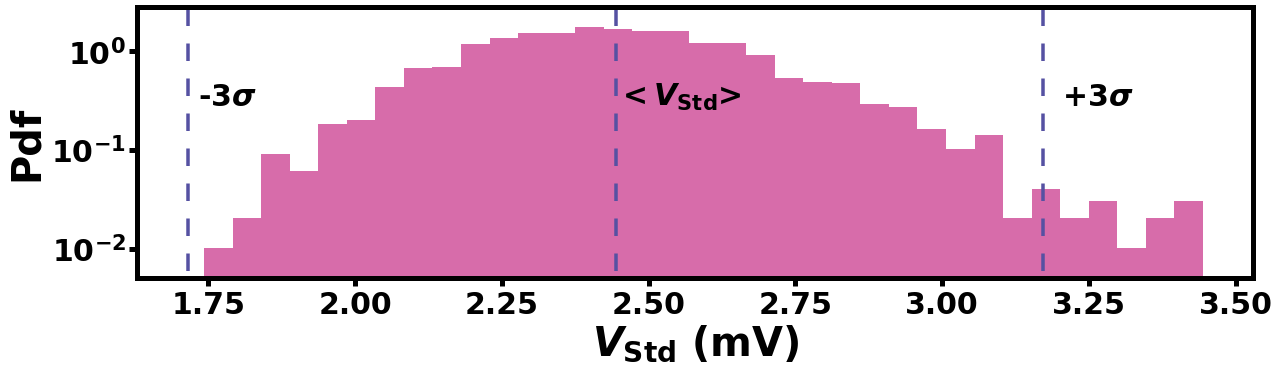

In [8]:
VRMSBinHist(StNr,ChNr, DataSample,DataFileId,BinNr=71)

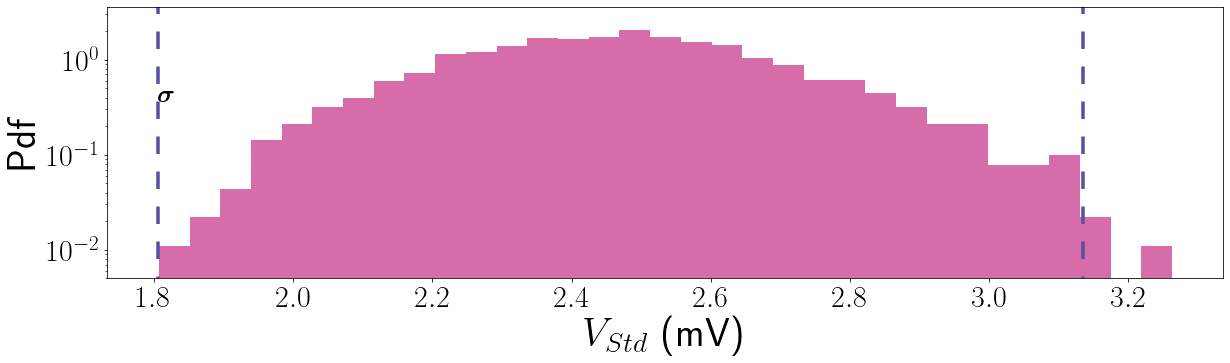

In [8]:
VRMSBinHist(StNr,ChNr, DataSample,DataFileId,BinNr=0)

In [3]:
StNr,ChNr,DataSample,DataFileId=23,16,"HC","3277351-Tot"

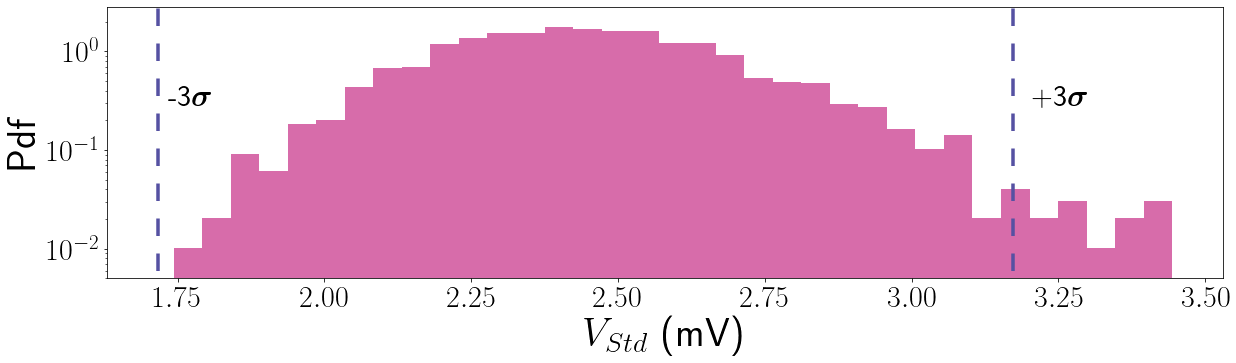

In [36]:
VRMSBinHist(StNr,ChNr, DataSample,DataFileId,BinNr=71)

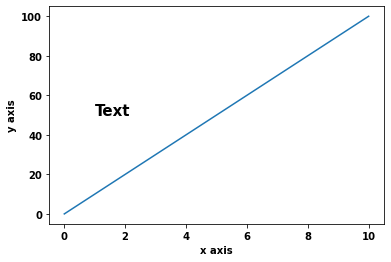

In [11]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
plt.figure()
matplotlib.rcParams['font.weight'] = 'bold'
plt.plot(np.linspace(0,10,20),np.linspace(0,100,20))
plt.xlabel("x axis",weight="bold")
plt.ylabel("y axis",weight="bold")
plt.text(1,50,"Text",fontsize=15)
plt.show()

## Galaxy position VS LST

In [ ]:
def GalPosLST(Angle, NSteps):
    """Angle in degrees"""
    import astropy
    
    FOVDecLimit=(72+ 34/60)-90
    pixel_longitudes, pixel_latitudes = hp.pixelfunc.pix2ang(n_side, range(hp.pixelfunc.nside2npix(n_side)), lonlat=True)
    galactic_coordinates = astropy.coordinates.Galactic(l=0, b=Angle*(np.pi/180) * astropy.units.rad)
    ICRS_coordinates = galactic_coordinates.transform_to(astropy.coordinates.ICRS)
    Decs=np.array([ICRS_coordinates[i].dec.degree for i in range(len(ICRS_coordinates))])
    radio_sky=np.ma.masked_where(Decs<FOVDecLimit, radio_sky, copy=True)

In [40]:
def GalPosLST(Angle=0,NSteps=23):
    import astropy
    from astropy.time import Time
    from astropy.coordinates import EarthLocation
    from astropy import units as u
    #import matplotlib.pyplot as plt 
    observing_location = EarthLocation(lat=72.598265*u.deg, lon=-38.459936*u.deg)
    t0,t1=Time("2023-01-01T00:00:00", format='isot', scale='utc',location=observing_location),Time("2023-01-02T00:00:00", format='isot', scale='utc',location=observing_location)
    UTCTimes=t0+(t1-t0)* np.linspace(0., 1., NSteps)[:-1]
    gal_coord = astropy.coordinates.Galactic(l=Angle*(np.pi/180) * astropy.units.rad, b=0 * astropy.units.rad)
    hor_coord = [gal_coord.transform_to(astropy.coordinates.AltAz(obstime=time,location=observing_location)) for time in UTCTimes]
    Alts=[coord.alt.degree for coord in hor_coord]
    # isot=YYYY-MM-DDThh:mm:ss
    LSTTimes=[time.sidereal_time('mean').hour for time in UTCTimes]
    fig=plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    plt.grid(color='grey', linestyle='-', linewidth=1,alpha=0.5)
    plt.scatter(LSTTimes, Alts,s=200,color="#d76caa",zorder=2)
    plt.plot(np.linspace(0,24,100),np.zeros(100),'k',linestyle='--',linewidth=2,alpha=0.75)
    #plt.title("Altitude of Gal(l,b)=(" + str(Angle) + ",0) at Summit Station",fontsize=30)
    plt.title("Altitude of the galactic centre at Summit Station",fontsize=25,weight="bold")
    plt.xlabel("LST Time (hrs)",fontsize=20,weight="bold")#20)
    plt.ylabel("Altitude",fontsize=20,weight="bold")#20)
    plt.xticks(np.arange(0, 25, 2.0),fontsize=25,weight="bold")#15)
    plt.yticks(fontsize=25,weight="bold")#15) 
    plt.ylim(-90,90)
    plt.xlim(0,24)
    ax.xaxis.set_tick_params(width=5,length=8)
    ax.yaxis.set_tick_params(width=5,length=8)
    plt.setp(ax.spines.values(), lw=5, color='k')
    plt.savefig("Figures/GalPosLST_l"+str(Angle)+"b0.pdf", format="pdf", bbox_inches="tight")
    plt.show()
    return

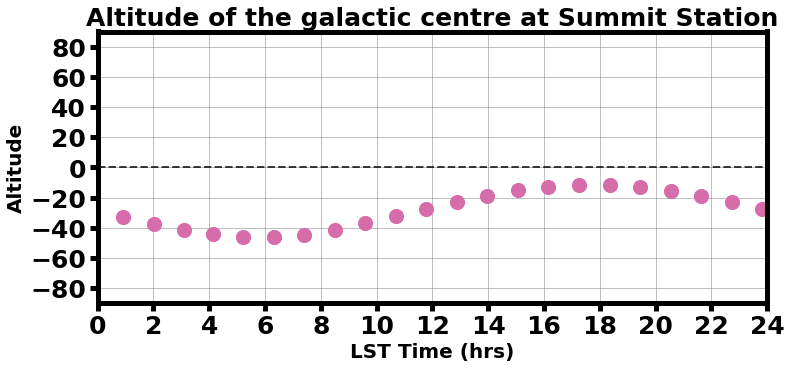

In [41]:
GalPosLST(Angle=0,NSteps=23)

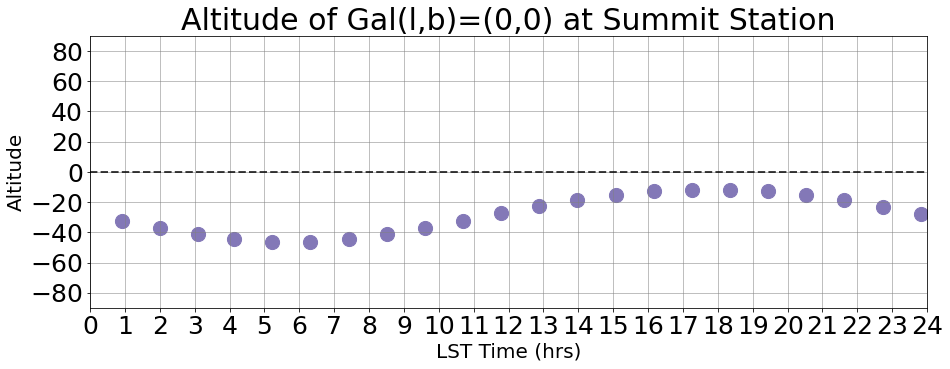

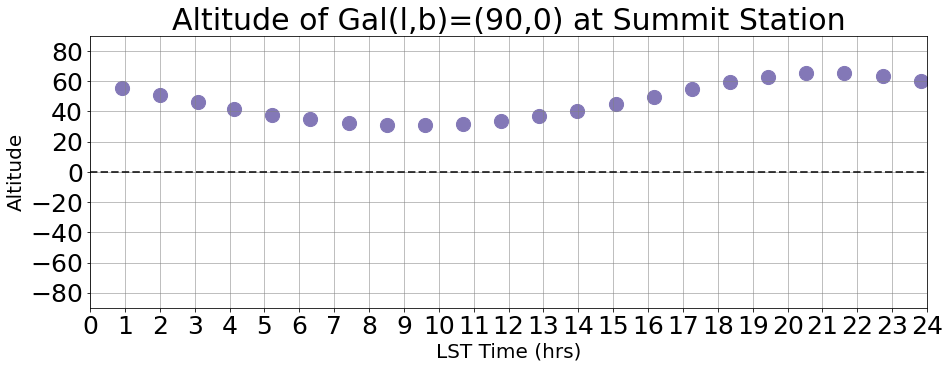

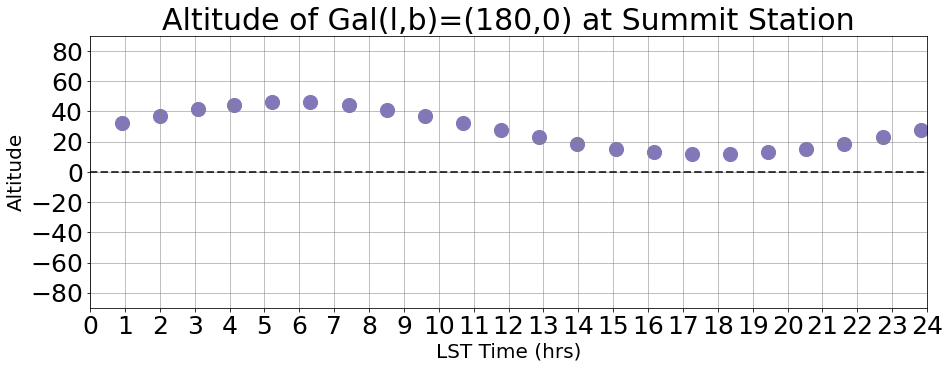

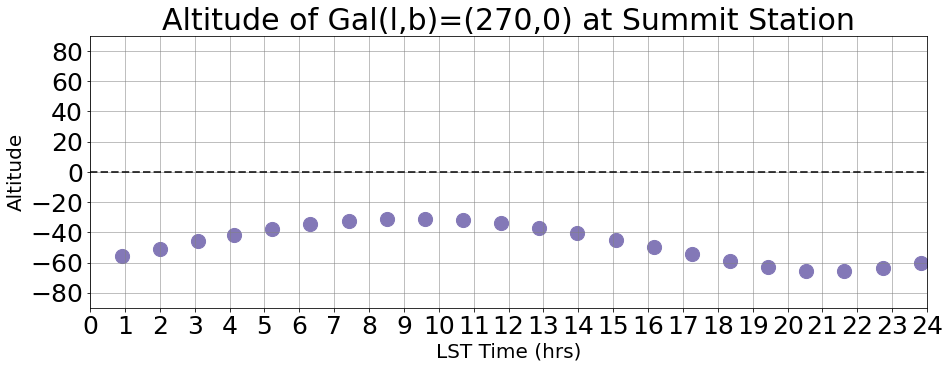

In [153]:
for angle in [0,90,180,270]:
    GalPosLST(Angle=angle,NSteps=23)